# LSTM - bert128

- **Training set**: LO_SARD102
- **Test/Validation set:** JTT
- **Features**: bert sequence (128)
- **Class imbalance processing**: Undersample

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter

X_train = numpy.load('/mnt/md0/user/scheuererra68323/LOSARD102_bert128_X.npy')
Y_train = pd.read_hdf('/mnt/md0/user/scheuererra68323/LOSARD102_bert128_y.h5').is_vulnerable.values

X_test = numpy.load('/mnt/md0/user/scheuererra68323/JTT_bert128_X.npy')
Y_test = pd.read_hdf('/mnt/md0/user/scheuererra68323/JTT_bert128_y.h5').is_vulnerable.values


X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=10
)

# undersample class 0
X_train, Y_train = undersample(np.reshape(X_train, (-1, 128*768)), Y_train)
X_train = np.reshape( X_train, (-1, 128, 768) )
print("class counts undersampled data set:", Counter(Y_train))

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

class counts undersampled data set: Counter({0: 366, 1: 366})
(732, 128, 768)
(732,)
(10238, 128, 768)
(10238,)
(7972, 128, 768)
(7972,)


In [10]:
def run_classifier(_X_train, _Y_train, _X_val, _Y_val):
    model = keras.Sequential()
    model.add(layers.LSTM(256, input_shape=(_X_train.shape[1], _X_train.shape[2]), 
                          return_sequences=True))
    model.add(layers.Dropout(0.1))
    model.add( layers.TimeDistributed(layers.Dense(16)) )
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy']
                 )
    
    
    history = model.fit(_X_train, _Y_train,
                        batch_size=64,
                        epochs=12,
                        verbose=True,
                        validation_data=(_X_val, _Y_val)
                        )
    
    return model, history


model, history = run_classifier(X_train, Y_train, X_val, Y_val)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128, 256)          1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 256)          0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 128, 16)           4112      
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2049      
Total params: 1,055,761
Trainable params: 1,055,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
12/12 [==============================] - 6s 461ms/step - loss: 0.2815 - accuracy: 0.8593 - val_loss

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7879
           1       0.06      0.06      0.06        93

    accuracy                           0.98      7972
   macro avg       0.53      0.53      0.53      7972
weighted avg       0.98      0.98      0.98      7972

Confusion matrix:
[[7788   91]
 [  87    6]]

Confusion matrix (Percentages):
[[9.7692e+01 1.1410e+00]
 [1.0910e+00 7.5000e-02]]

Metrics:
Sensitivity (TPR): 0.064516
Specifity (TNR):   0.988450

FPR: 0.011550
FNR: 0.935484

Balanced accuracy: 0.526483

Test loss:	0.072607
Test accuracy:	0.977672


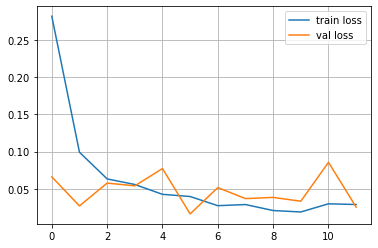

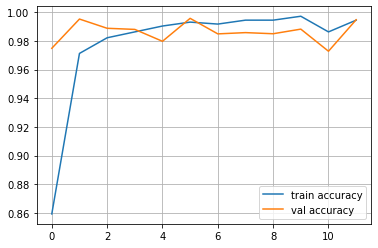

In [11]:
def evaluate_classifier(_model, _history):
    Y_pred = numpy.round(_model.predict(X_test))

    print(classification_report(Y_test, Y_pred))
    print_metrics(confusion_matrix(Y_test, Y_pred), Y_test)
    print()
    score = _model.evaluate(X_test, Y_test, verbose=False)
    print('Test loss:\t{:.6f}'.format(score[0]))
    print('Test accuracy:\t{:.6f}'.format(score[1]))

    plot_loss(_history)
    plot_accuracy(_history)


evaluate_classifier(model, history)

In [12]:
model.save('testJTT_LSTM_bert128_undersample.h5')